In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_bart as pmb

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
RANDOM_SEED = 4579
np.random.seed(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
funcs = [
    lambda x: 10 * x,
    lambda x: 10 * np.sin(x * 2 * np.pi),
    lambda x: 2 - 4 * np.where(x < 0.5, 1, 0),
]

In [4]:
X_lin = np.linspace(0, 1, 200)
Y_lin = np.random.normal(funcs[0](X_lin), 2, size=200)
X_lin = X_lin[:, None]

X_sin = np.linspace(0, 1, 200)
Y_sin = np.random.normal(funcs[1](X_sin), 2, size=200)
X_sin = X_sin[:, None]

X_stp = np.linspace(0, 1, 200)
Y_stp = np.random.normal(funcs[2](X_stp), 0.2, size=200)
X_stp = X_stp[:, None]

XS = [X_lin, X_sin, X_stp]
YS = [Y_lin, Y_sin, Y_stp]

In [5]:
idatas = []
m_trees = []
for X, Y in zip(XS, YS):
    for m in [10, 50, 200]:
        with pm.Model() as functions:
            σ = pm.HalfNormal("σ", Y.std())
            μ = pmb.BART("μ", X, Y, m=m)
            y = pm.Normal("y", μ, σ, observed=Y)
            idata = pm.sample(
                chains=4,
                random_seed=RANDOM_SEED,
                compute_convergence_checks=False,
                idata_kwargs={"log_likelihood": True},
            )
            idatas.append(idata)
            m_trees.append(μ.owner.op.m)

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Output()

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


Output()

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 287 seconds.


Output()

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Output()

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.


Output()

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 272 seconds.


Output()

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Output()

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


Output()

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 279 seconds.


Output()

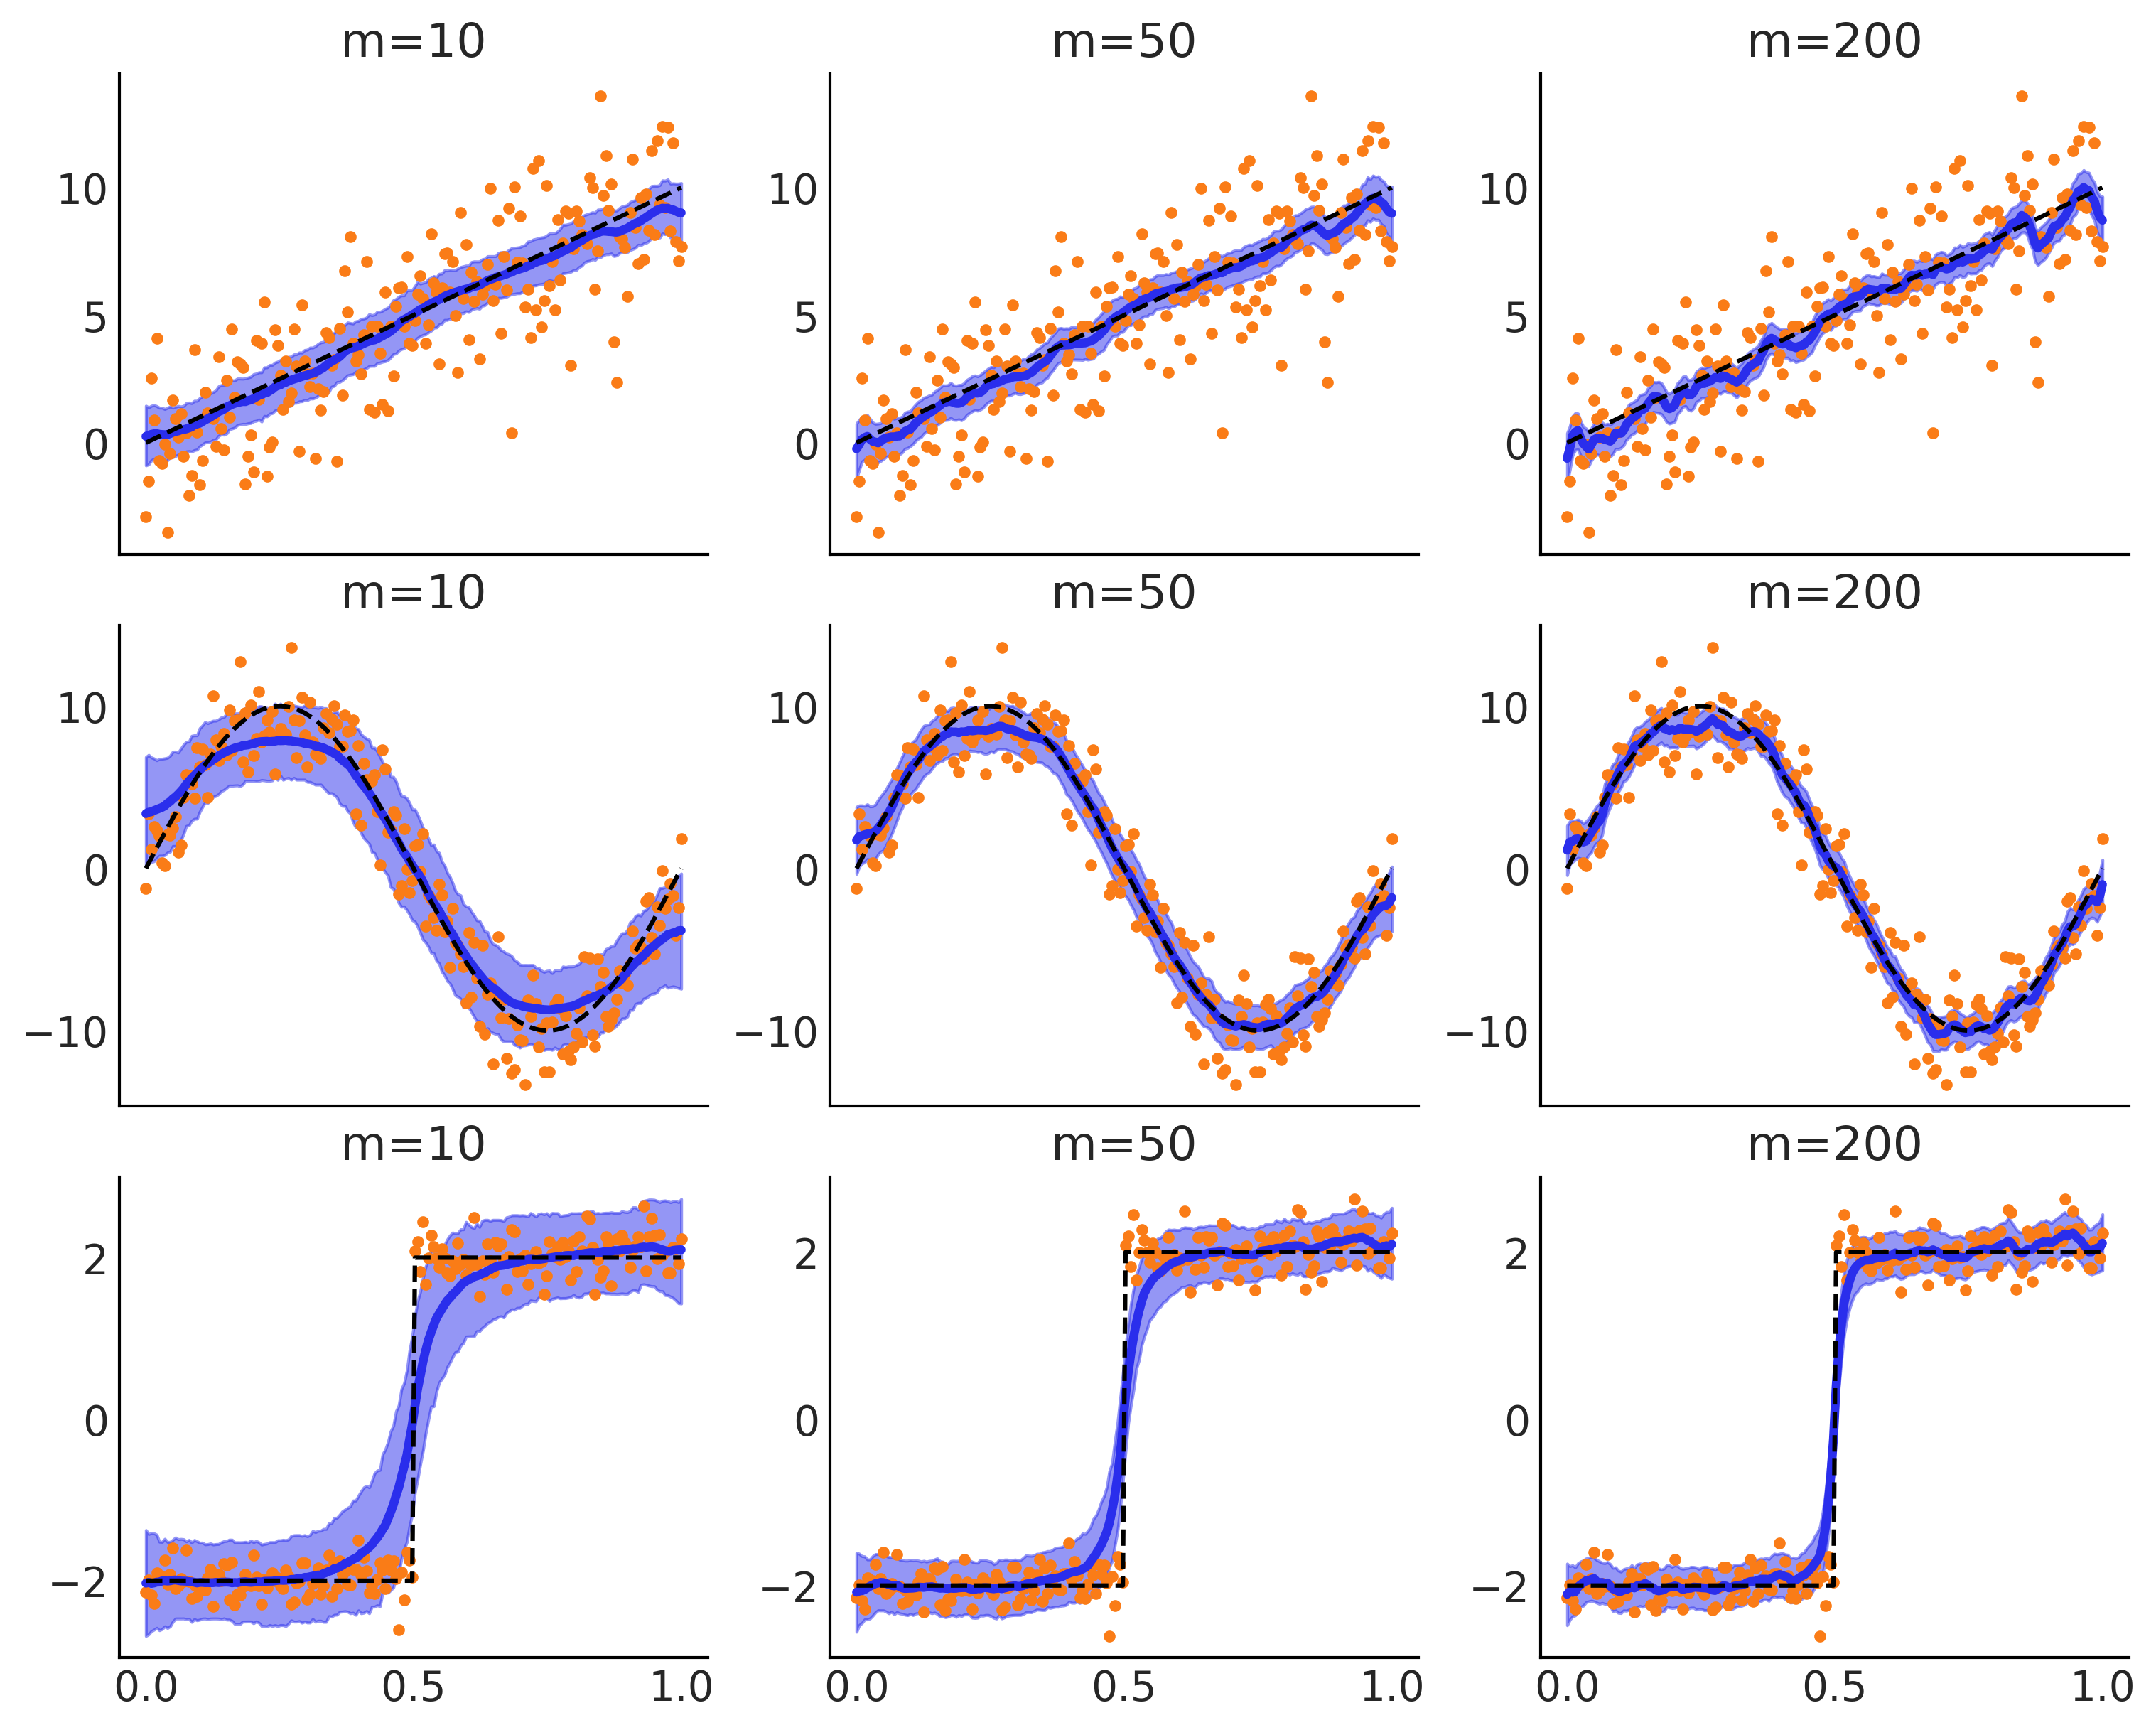

In [6]:
_, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=True)


for idata, m, ax, X, Y, f in zip(
    idatas,
    m_trees,
    np.ravel(axes),
    np.repeat(XS, 3, 0),
    np.repeat(YS, 3, 0),
    np.repeat(funcs, 3),
):
    mean = idata.posterior["μ"].mean(dim=["draw", "chain"])
    ax.plot(X[:, 0], mean, lw=3)
    az.plot_hdi(X[:, 0], idata.posterior["μ"], color="C0", smooth=False, ax=ax)
    ax.plot(X[:, 0], Y, ".", zorder=1)
    ax.plot(X[:, 0], f(X), "k--")
    ax.set_title(f"{m=}")
    plt.savefig("simple_function.png")

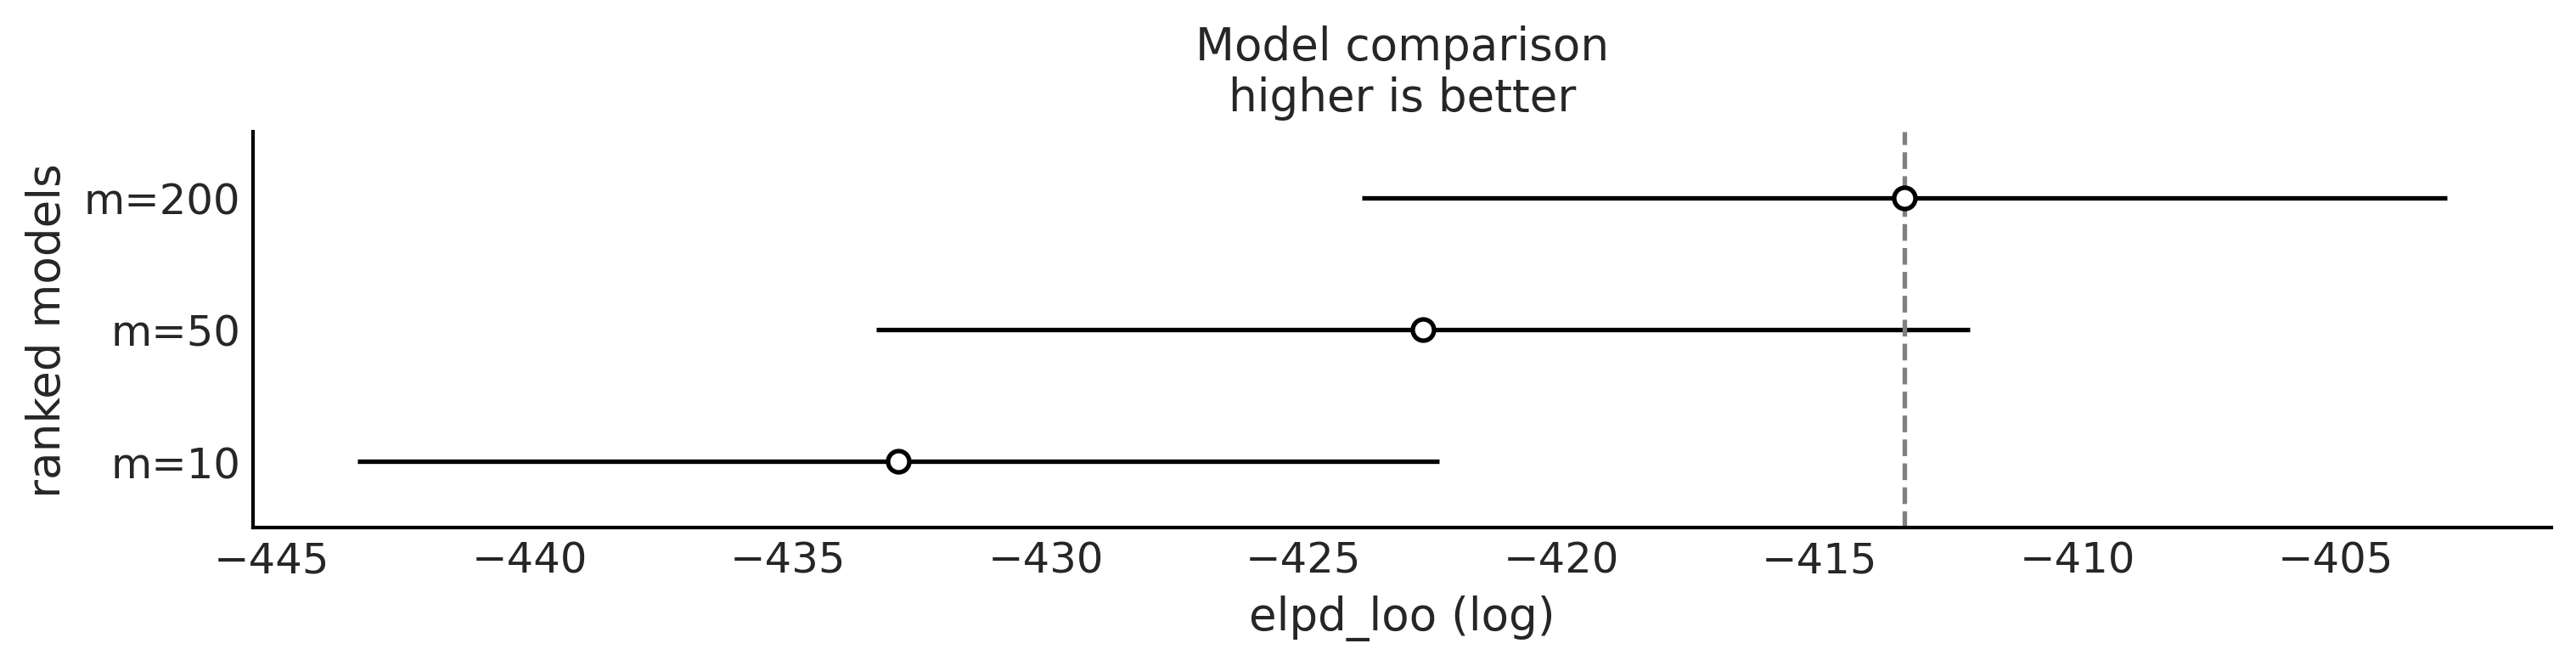

In [7]:
cmp = az.compare(dict(zip(["m=10", "m=50", "m=200"], idatas[:3])))
ax = az.plot_compare(
    cmp, plot_ic_diff=False, insample_dev=False, figsize=(10, 2.5), legend=False
)
plt.savefig("LOO_lin.png")

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


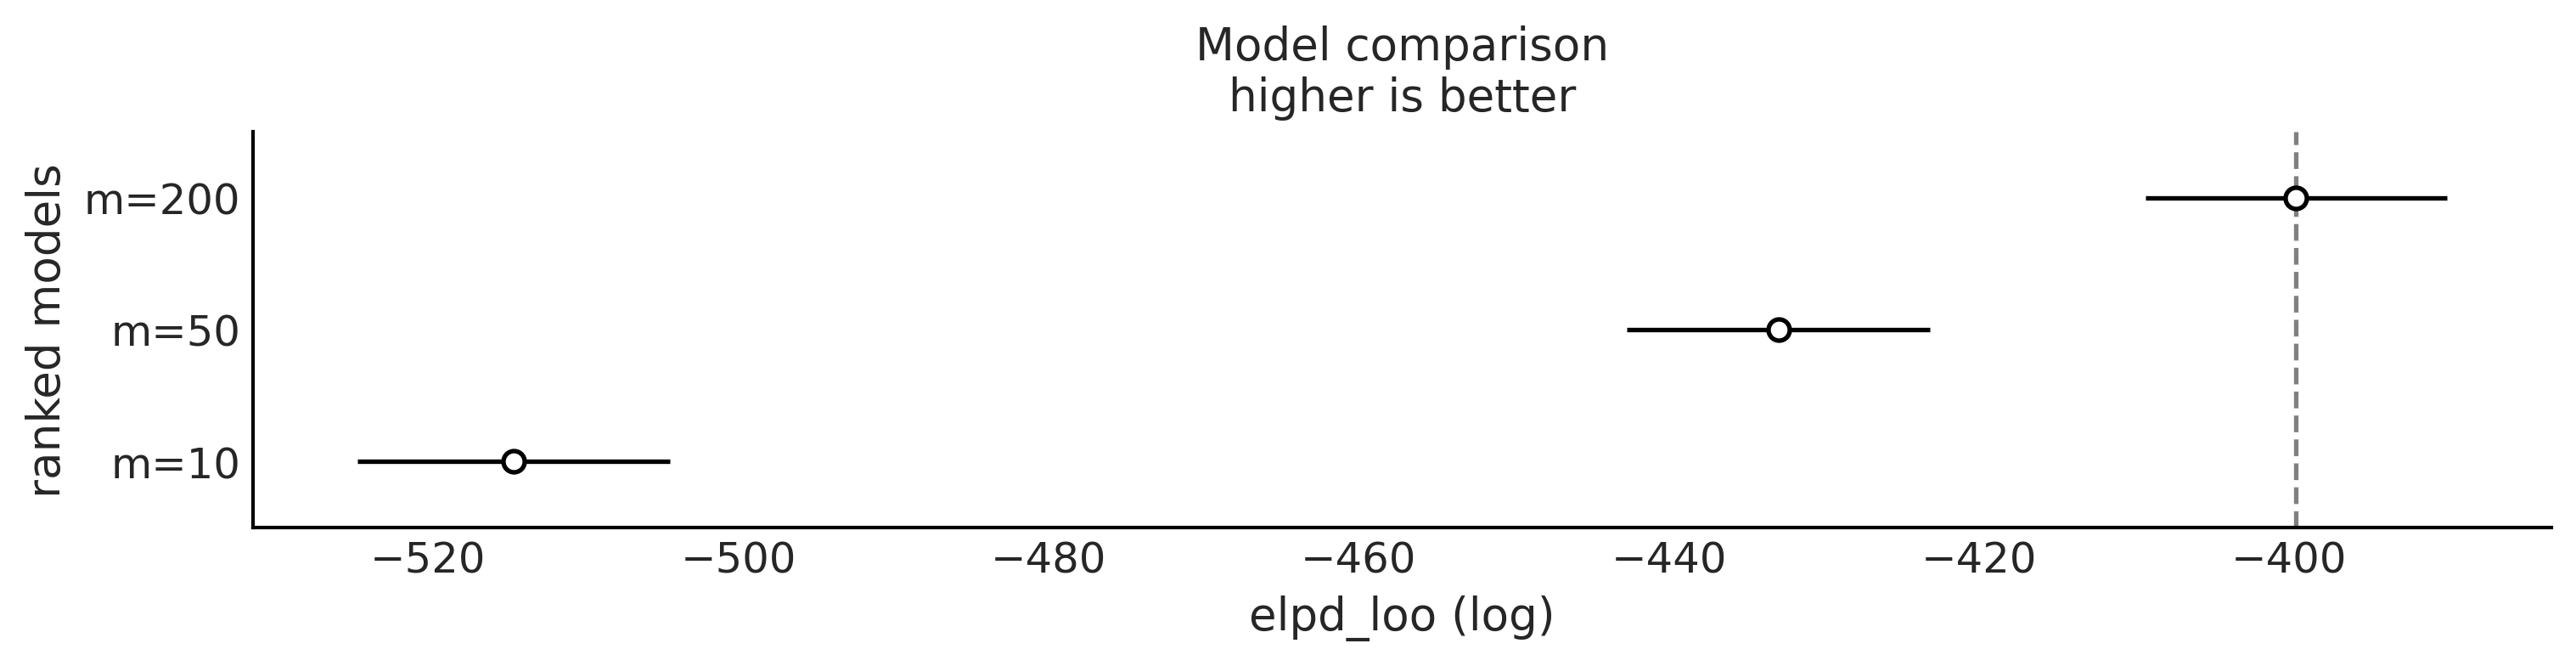

In [8]:
cmp = az.compare(dict(zip(["m=10", "m=50", "m=200"], idatas[3:6])))
ax = az.plot_compare(
    cmp, plot_ic_diff=False, insample_dev=False, figsize=(10, 2.5), legend=False
)
plt.savefig("LOO_sin.png")

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.10/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.10/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.10/site-packages/arviz/stats/stat

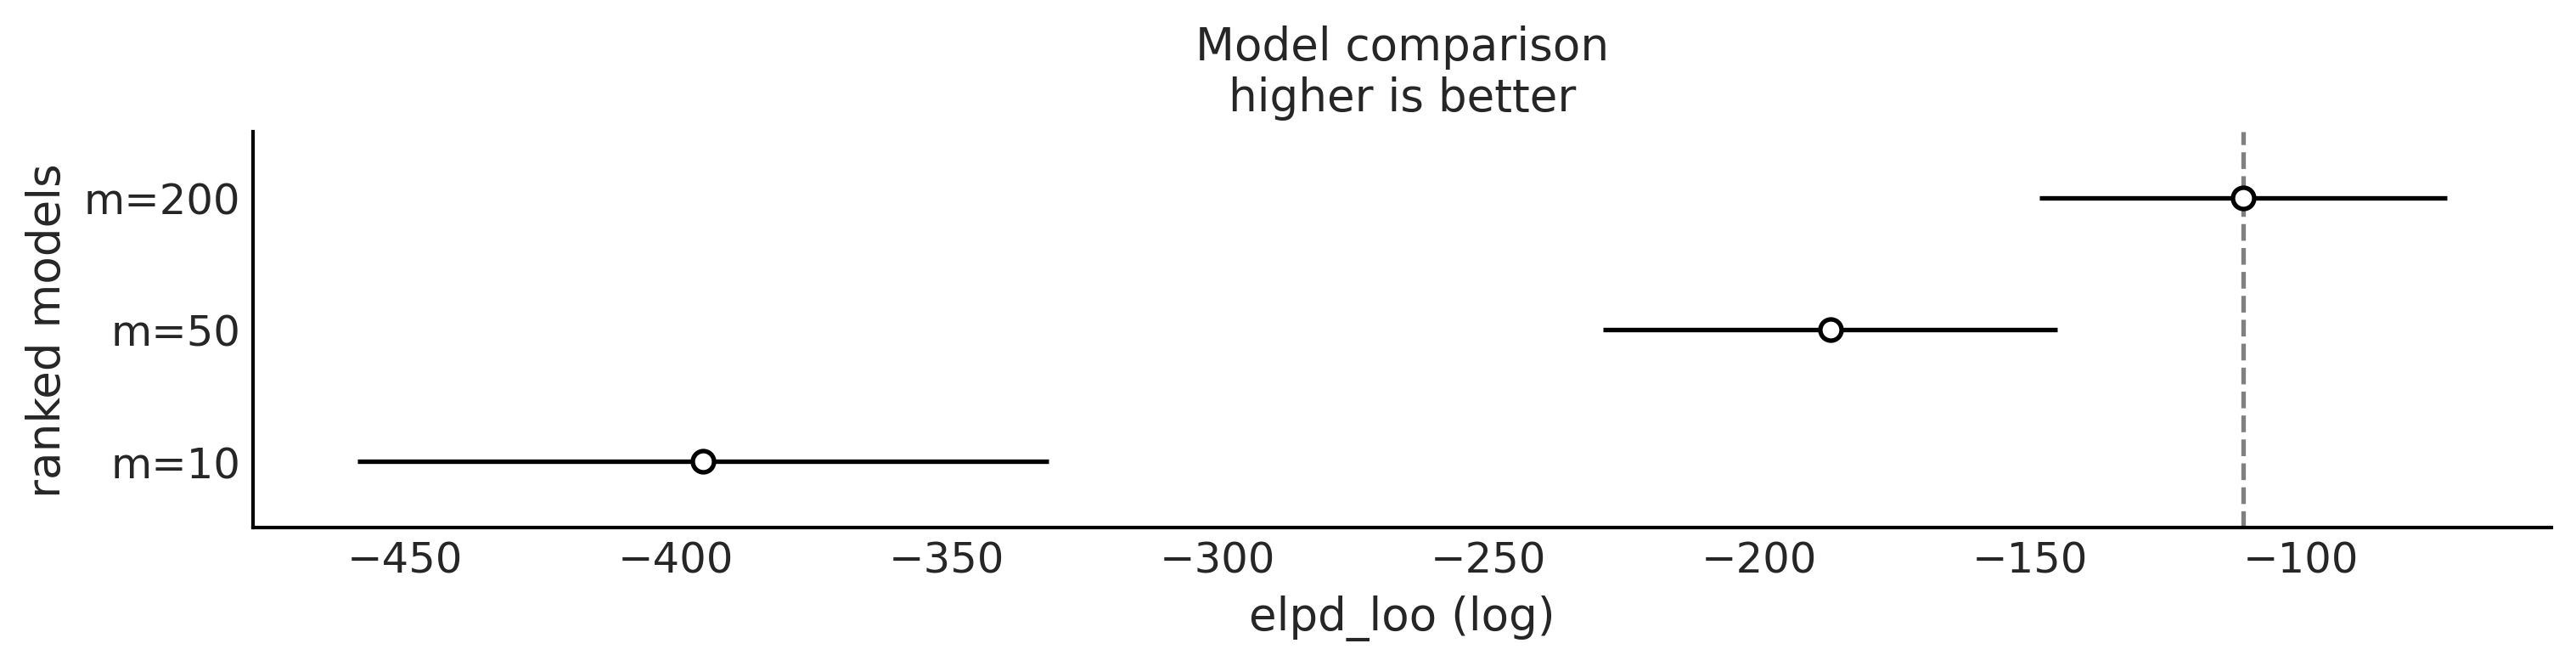

In [9]:
cmp = az.compare(dict(zip(["m=10", "m=50", "m=200"], idatas[6:])))
ax = az.plot_compare(
    cmp, plot_ic_diff=False, insample_dev=False, figsize=(10, 2.5), legend=False
)
plt.savefig("LOO_stp.png")